# S32407- Learn how to use GPU's for more Accurate Backtesting of Equity Investment Strategies, NVIDIA

## Part 1: Top Sharpe Ratio Investment Selection

[Mark J. Bennett, Ph.D., contact info: mbennett@nvidia.com]
[Financial Analytics book website](http://cambridge.org/FAR)

Our first of two notebooks focuses on how to compute accurate returns and
measure volatility. Then using using return and volatility we will examine
the Sharpe Ratio, which simply divides the two statistics, as our way
to judge the investment performance of all the stocks in the NYSE and
NASDAQ markets.

The Sharpe Ratio scales the log returns of a security by a measure of risk incurred by the investor.
So we penaize for risk and reward for consistency. The best securites of all
have high return and low risk.

Our time window is November 2020 and 3 years prior to that point in time.
Our price quote are at the end of day close with adjustments for any stock splits and added dividends.
Yahoo! offers a quoting service and we have accessed that, as explained in the
Financial Analytics book via the get.hist.quote() function in R and then gathered them
into 2 very wide data frames (NYSE and NASDAQ) ready for importing here.

## Definition: Sharpe Ratio for an Individual Stock Security

<font size="+1">A Security $j$ with $n$ Log Returns $R_j(t)$ for observations at $n+1$ times
$0,1,...,t-1,t$
<br><br>
has a Sharpe Ratio $SR_j(t)$ at time $t$:
$SR_j(t)={{E\{R_j\} - \mu_f} \over \sqrt{E\{(R_j - E\{R_j\})^2\} }}
= {{ \bar{x}_j - \mu_f} \over \sqrt{ {1 \over {n-1} } \sum_{t=1}^n (R_j(t) - \bar{x}_j)^2 }} $
where $\bar{x}_j = {1 \over n} \sum_{t=1}^n R_j(t)$
<br><br>
$
={{\bar{x}_j - \mu_f} \over s_j} \approx {\bar{x}_j \over s_j}
$  where the log returns $R_j(t) = log({S_j(t)} / {S_j(t-1)})$
<br><br>and $S_j(t)$ is the Stock Price at time $t$.
<br><br>For our purposes, times $t$ occur at the daily market close.</font>

## Annualizing Shape Ratios

<font size="+1">Our returns are daily and so is their volatility so we can scale them to become yearly,
making them larger.
There are 252 days in a typical trading year. To convert to annual Sharpe Ratios, begin with
the formula from above:
<br><br>
$
{{ 252 \cdot (\bar{x}_j - \mu_f)} \over \sqrt{ 252 \cdot {1 \over {n-1} } \sum_{t=1}^n (R_j(t) - \bar{x}_j)^2}}
\approx {{252 \cdot \bar{x}_j} \over \sqrt{ 252 \cdot {1 \over {n-1} } \sum_{t=1}^n (R_j(t) - \bar{x}_j)^2}}
= {{  \sqrt{252} \cdot \sqrt{252} \cdot \bar{x}_j \cdot} \over {\sqrt{252} \cdot \sqrt{ {1 \over {n-1} } 
\cdot \sum_{t=1}^n (R_j(t) - \bar{x}_j)^2 }}}
= \sqrt{252} \cdot  SR_j(t)
$
which says to multiply by $\sqrt{252}$ to annualize.

### Imports and Constant Settings

In [1]:
import numpy as np, sys, time
import pandas as pd, time
import matplotlib.pyplot as plt
np.set_printoptions(threshold=1000)
import warnings
warnings.filterwarnings('ignore')

k = 12 #top securities
blockSz = 256

fname1 = "data/MVO3.2020.08/NYSE/prices.csv"
fname2 = "data/MVO3.2020.08/NASDAQ/prices.csv"

### Compare Gross, Net, Log Returns; 1st loss $S(0)=100;S(t)=80$ then gain $S(0)=80;S(t)=100$

In [2]:
# A) Try Gross Return:
80.0/100

0.8

In [3]:
# B) Try Net Return:
80.0/100.0-1

-0.19999999999999996

In [4]:
# C) Try Gross Return:
100.0/80.0

1.25

In [5]:
# D) Try Net Return:
100.0/80.0-1

0.25

In [6]:
# E) Try Log Return:
np.log(80.0/100.0)

-0.2231435513142097

In [7]:
# F) Try Log Return:
np.log(100.0/80.0)

0.22314355131420976

### Note above: symmetry of Log Returns and similarity of Net Returns to Log Returns

In [8]:
import math
math.isclose(np.log(100.0/80.0), -np.log(80.0/100.0), rel_tol=0.000001)

True

### Start GPU with a Null Kernel written in Numba which simply writes index i into array arr[]
### Observe the time in seconds can be thought of in seconds x 10^(-6) or microseconds

In [9]:
import numpy
from numba import cuda
import cupy

@cuda.jit
def add(aryA, aryB, useBlockIdx=True):
  j = (cuda.blockIdx.x * cuda.blockDim.x+cuda.threadIdx.x) if useBlockIdx else cuda.threadIdx.x
  if j < aryA.shape[0]:
    aryB[j] = aryA[j]+aryA[j]

import time
aryA = cupy.arange(20, dtype=cupy.int32)
aryB = numpy.arange(20, dtype=cupy.int32)
start = time.time()
add[2, 20](aryA, aryB, False) #blockDim is 2 and threadDim is 16
print(time.time()-start,aryA,'\n',aryB)

0.25006532669067383 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
 [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 16 17 18 19]


### Inspect NYSE Stock price data where final day is 2020.08.21
### Observe 2 file lengths for NYSE and NASDAQ: header row on top

In [10]:
! echo first two lines of one of two prices files:
! head -2 data/MVO3.2020.08/NYSE/prices.csv
! echo prices files contain three years of daily prices for two exchanges:
! wc data/MVO3.2020.08/*/prices.csv

first two lines of one of two prices files:
CTBB,DY,ADM,NPV,SQNS,HMN,VEC,FRC,CABO,DTY,KRG,AXL,HUBB,SCHW,SHW,UBA,WBK,PSX,EV,ESNT,SF,PDM,JTD,LIN,NAV,ADS,RLJ,PBH,UNVR,PVH,NC,BWA,COP,PVG,VER,WMT,NXP,RMT,NCR,ATHM,DTF,SCI,JBT,FLY,IVR,CBH,SKT,AWR,SHAK,PE,V,MYOV,SRV,RDY,VBF,NAZ,CMP,IAG,GOF,NM,NWHM,CTR,PGP,TRNO,AM,TGP,CXW,SAM,CB,ABT,PRA,CUZ,RVT,MAXR,VIPS,JHG,CHT,FDP,SUZ,CHU,MDU,SAR,TTI,IPG,LAD,CNDT,ESRT,KMB,ASG,FBHS,STM,VGM,INVH,NBHC,ISD,WIT,TLYS,CHN,BSAC,RNGR,SHLX,FMX,NOM,NMT,A,EVT,MGM,IID,CCM,REVG,DL,TR,MGY,MDT,BNED,HON,IO,AG,EXC,GPMT,VNCE,UE,KBR,BIG,BTZ,SWX,SYX,ACP,PRU,NXR,BK,LEE,NGVT,CBD,JWN,KNL,VLO,MCN,HYB,CNQ,CP,SYY,MAC,CHH,PRO,DDS,TIF,EZT,TAK,HII,PGTI,TRGP,PBI,KFY,APD,MGU,LYB,PFO,VLT,LH,ESS,GSL,GNK,MFGP,NMFC,MPA,ELVT,WAB,WAT,USPH,HNP,DE,PDT,ASB,EVRG,SHI,PCK,SU,ATH,EURN,BDJ,WM,TWN,DAR,SNAP,PM,FIX,JHS,HQH,AAP,ABBV,KKR,THO,ARGD,TREX,PFN,NBR,RHP,ACN,CLGX,HASI,VTR,MCD,ZEN,TJX,BLX,MYI,CHL,JBK,FBC,CIF,GKOS,MUSA,CS,AGR,GPN,SUPV,PMM,KMPR,HEI,SCM,PJT,MTOR,NLS,CTS,BA,RZB,TVC,CIO,JBL,DUKH,NSA,NSC,FE

prices files contain three years of daily prices for two exchanges:
     756      756 13124434 data/MVO3.2020.08/NASDAQ/prices.csv
     756      756 14687131 data/MVO3.2020.08/NYSE/prices.csv
    1512     1512 27811565 total


### Read 2 prices.csv files (NYSE and NASDAQ) with ticker symbols in header row and prices in columns

In [11]:
def readPrices():
    #read NYSE and NASDAQ: 2 separate price files
    df1 = pd.read_csv(fname1)
    df2 = pd.read_csv(fname2)
    return pd.concat([df1, df2], axis=1)

#merge the ticker label sets:
df = readPrices()
prices = df.values
lab  = df.columns.values.tolist()
print('All tickers:')
print(lab);print(len(lab))
df.head()

All tickers:
['CTBB', 'DY', 'ADM', 'NPV', 'SQNS', 'HMN', 'VEC', 'FRC', 'CABO', 'DTY', 'KRG', 'AXL', 'HUBB', 'SCHW', 'SHW', 'UBA', 'WBK', 'PSX', 'EV', 'ESNT', 'SF', 'PDM', 'JTD', 'LIN', 'NAV', 'ADS', 'RLJ', 'PBH', 'UNVR', 'PVH', 'NC', 'BWA', 'COP', 'PVG', 'VER', 'WMT', 'NXP', 'RMT', 'NCR', 'ATHM', 'DTF', 'SCI', 'JBT', 'FLY', 'IVR', 'CBH', 'SKT', 'AWR', 'SHAK', 'PE', 'V', 'MYOV', 'SRV', 'RDY', 'VBF', 'NAZ', 'CMP', 'IAG', 'GOF', 'NM', 'NWHM', 'CTR', 'PGP', 'TRNO', 'AM', 'TGP', 'CXW', 'SAM', 'CB', 'ABT', 'PRA', 'CUZ', 'RVT', 'MAXR', 'VIPS', 'JHG', 'CHT', 'FDP', 'SUZ', 'CHU', 'MDU', 'SAR', 'TTI', 'IPG', 'LAD', 'CNDT', 'ESRT', 'KMB', 'ASG', 'FBHS', 'STM', 'VGM', 'INVH', 'NBHC', 'ISD', 'WIT', 'TLYS', 'CHN', 'BSAC', 'RNGR', 'SHLX', 'FMX', 'NOM', 'NMT', 'A', 'EVT', 'MGM', 'IID', 'CCM', 'REVG', 'DL', 'TR', 'MGY', 'MDT', 'BNED', 'HON', 'IO', 'AG', 'EXC', 'GPMT', 'VNCE', 'UE', 'KBR', 'BIG', 'BTZ', 'SWX', 'SYX', 'ACP', 'PRU', 'NXR', 'BK', 'LEE', 'NGVT', 'CBD', 'JWN', 'KNL', 'VLO', 'MCN', 'HYB', 'CN

,CTBB,DY,ADM,NPV,SQNS,HMN,VEC,FRC,CABO,DTY,...,TWIN,PPBI,CHI,VERI,TAYD,INTU,ICPT,ICCC,SNBR,ESGR
0,20.441338,82.059998,37.333767,11.411190,12.80,32.237148,28.219999,95.414185,727.732971,22.477062,...,16.959999,33.666492,8.182853,13.190000,10.85,134.020370,112.010002,5.98,30.040001,203.199997
1,20.503246,82.099998,37.306953,11.506426,12.40,32.191872,28.370001,94.136513,720.367920,22.547781,...,17.040001,32.605766,8.190079,15.040000,11.11,134.127258,112.580002,6.02,29.670000,201.649994
2,20.568413,76.070000,37.414204,11.480454,12.60,32.191872,28.730000,94.663177,731.776123,22.489542,...,17.080000,32.651886,8.255137,16.660000,11.15,136.032120,114.099998,6.15,29.570000,201.399994
3,20.658018,80.680000,36.931568,11.489111,12.40,31.829653,28.580000,94.653427,739.180237,22.630985,...,17.360001,32.651886,8.269595,15.560000,11.75,137.470459,116.610001,5.81,29.530001,207.550003
4,20.601812,81.760002,37.718094,11.480454,12.72,31.829653,28.889999,94.975281,737.728394,22.664267,...,17.360001,32.651886,8.298509,16.309999,11.70,137.907806,118.750000,6.12,30.450001,206.800003


### Observe dimensions of prices matrix S and also find dimensions of log ret matrix R

In [12]:
#obtain price data:
print(prices.shape)
Nminus1 = prices.shape[0]-1
pp = prices.shape[1]
print(Nminus1);print(pp)

(755, 4314)
754
4314


### Find R from S using findR()

In [13]:
def findR(prices,pp):
  #compute log returns by column j:
  Nminus1 = prices.shape[0]-1; pp = prices.shape[1]
  R = np.empty([Nminus1, pp]).astype(np.float32)
  for j in range(0,pp):
    R[:,j] = np.diff(np.log(prices[:,j]))
  return R

start = time.time()
findR(prices,pp)
end   = time.time()
print ("%fs" % ((end-start)))

0.083767s


In [14]:
import cudf, numba, cupy
from cupy import log,diff
from numba import cuda
print('cudf.__version__',cudf.__version__,'numba.__version__',numba.__version__,
      'cupy.__version__',cupy.__version__)

@cuda.jit()
def findR(prices,R,pp):
  #compute log returns by column j:
  j = cuda.blockIdx.x * cuda.blockDim.x+cuda.threadIdx.x
  #for j in range(0,pp):
  if j < pp:
    for i in range(0,prices.shape[0]-1):
      R[i,j] = math.log(prices[i+1,j]) - math.log(prices[i,j]) #cupy.diff(cupy.log(prices[:,j]))
    
print('pp',pp)  
Nminus1 = prices.shape[0]-1; pp = prices.shape[1]
R_result = cupy.empty([Nminus1, pp]).astype(np.float32)
%timeit findR[(blockSz,1,1), (256,1,1)](prices,R_result,pp)
start = time.time()
findR[(blockSz,1,1), (256,1,1)](prices,R_result,pp)
print(time.time()-start,'secs')
#cudf.DataFrame(R[0:4,:]).tail(5)
R_result.shape
R = R_result.get()

cudf.__version__ 0.17.0 numba.__version__ 0.53.0 cupy.__version__ 8.5.0
pp 4314
15.6 ms ± 479 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
0.014322519302368164 secs


### Observe price charts for 4 typical security names and also log ret plot

Populating the interactive namespace from numpy and matplotlib


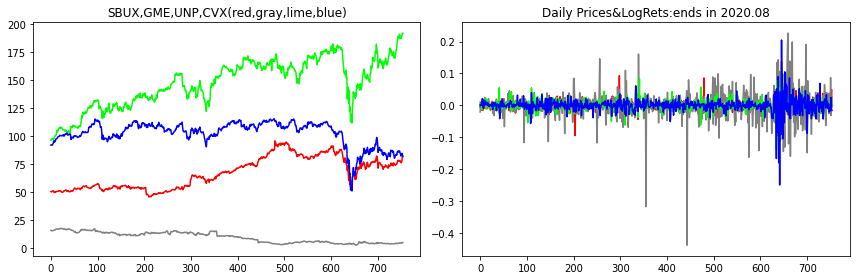

In [32]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 4)

def plotSec(symbs,lab,prices,R):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  axList = axes.flatten()
  axIdx = 0; colors = ['red','gray','lime','blue']
  for symb in symbs:
    idx = np.where(np.array(lab)==symb)[0][0]
    axList[0].set_title(','.join(symbs)+'('+','.join(colors)+')')
    axList[0].plot(range(0,prices.shape[0]), prices[:,idx],color=colors[axIdx])
    axList[1].set_title("Daily Prices&LogRets:ends in "+'.'.join(fname1.split('/')[1].split('.')[1:3]))
    #plt.subplot(1, 2, 2)
    axList[1].plot(range(0,prices.shape[0]-1),
                   np.round(R[:,idx],3),color=colors[axIdx])
    axIdx += 1
  fig.tight_layout()
  plt.show()

plotSec(["SBUX","GME","UNP","CVX"],lab,prices,R)

### Get to know data: shape, 1st name, 1st row of prices, 1st row of R, mean&std of last col

In [16]:
def printData(prices,R):
    print(type(R))
    print(R.shape)
    pp = R.shape[1]
    print(lab[0])
    print("prices[:,0]")
    print(prices[:,0])
    print("R[:,0]")
    print(R[:,0])
    print('1st R col',R[:,0]);print("mean std R[:,0]")
    print(np.mean(R[:,0]));print(np.std(R[:,0]))
    print('last R col',R[:,pp-1]);print("mean std R[:,pp-1]")
    print(np.mean(R[:,pp-1]));print(np.std(R[:,pp-1]))
    
printData(prices,R)

<class 'numpy.ndarray'>
(754, 4314)
CTBB
prices[:,0]
[20.441338 20.503246 20.568413 20.658018 20.601812 20.576559 20.609142
 20.641729 20.527685 20.625437 20.69875  20.658018 20.625437 20.674311
 20.633583 20.576559 20.568413 20.543974 20.601    20.568413 20.535828
 20.535828 20.543974 20.592852 20.568413 20.568413 20.511393 20.486956
 20.511393 20.584705 20.535828 20.584705 20.625437 20.666166 20.649872
 20.682455 20.649872 20.674311 20.723188 20.820936 20.666166 20.625437
 20.666166 20.584705 20.543974 20.568413 20.592852 19.753822 19.721239
 19.517591 19.297655 18.320147 18.312    18.67856  18.955523 18.979961
 19.118443 19.403549 19.566469 19.346527 18.629688 18.760023 19.036985
 19.15917  19.175465 19.102152 19.028839 19.0044   18.865923 18.833338
 18.694853 18.751877 18.768171 18.874063 18.711145 18.727436 18.719294
 18.66227  18.800751 18.906645 18.841478 18.694853 18.735586 18.629688
 18.46677  18.499353 18.34458  17.448532 17.766222 17.920994 18.263124
 18.40975  18.279415 18.

### G) What is the shape of our prices data frame?

### H) What are the first 2 prices that we see for the security in column 0?

### I) If you can access the prior cell, what is the corresponding log return value for those 2 prices as seen in column slice R[:,0]?

### Find baseline timing to compute mass Sharpe ratio on CPU

In [17]:
def findSharpeRatiosCPU(R,meanv,sdevv,SR,pp):
  for j in range(0,pp):
    meanv[j] = np.mean(R[:,j])
    sdevv[j] = np.std(R[:,j])
    SR[j]    = meanv[j]/sdevv[j] 
  return meanv, sdevv, SR

meanv = np.empty([pp]).astype(np.float32)
sdevv = np.empty([pp]).astype(np.float32)
SR    = np.empty([pp]).astype(np.float32)

start = time.time()
meanv, sdevv, SR = findSharpeRatiosCPU(R,meanv,sdevv,SR,pp)
end   = time.time()
cputime = end - start
print(meanv[0],sdevv[0],SR[0],"%fs" % (cputime))

0.00024157735 0.023900239 0.010107738 0.165185s


### Routine is for bar chart of CPU vs. GPU

In [18]:
def plotBoth(cputime,gputime,mat):
  plt.bar([0,1],[cputime,gputime],align='center',alpha=.5)
  plt.xticks([0,1],('CPU time','GPU time'))
  plt.title('Sharpe Ratio computation timings after findSharpeRatiosKernel(), speedup = '+
          str(np.round(cputime/gputime,2)) + ', shape = ' + str(mat.shape))
  plt.show()

### Find GPU timing to compute mass Sharpe ratio using numba package

### Plot times for comparison

4.68 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
0.010114449 0.005856s


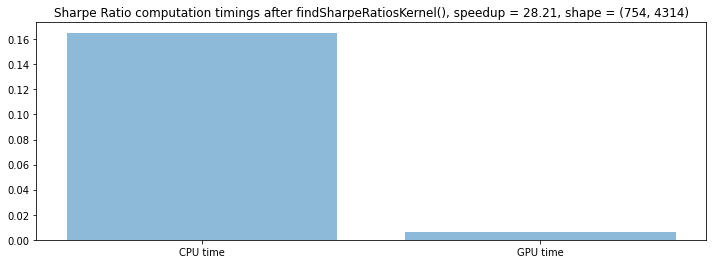

In [19]:
import cudf
import cupy
from numba import cuda

@cuda.jit
def findSharpeRatiosNumba(R, meanv, sdevv, SR, Nminus1, pp):
  #for j in range(0,pp): 
  j = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
  if j < pp:
    j = j
    for i in range(0,Nminus1): #compute pp means
        meanv[j] += R[i,j]
    meanv[j] /= Nminus1
    sdevv[j] = 0.0
    for i in range(0,Nminus1): #compute pp sdevs
        sdevv[j] += (R[i,j]-meanv[j])*(R[i,j]-meanv[j])
    sdevv[j] /= Nminus1-1 #if Nminus1 > 1 else 1
    sdevv[j] = math.sqrt(sdevv[j])
    SR[j]    = meanv[j]/sdevv[j] 

meanv = cupy.zeros(pp).astype(np.float32)
sdevv = cupy.zeros(pp).astype(np.float32)
SR    = cupy.zeros(pp).astype(np.float32)

#First time is mainly to compile it:
%timeit findSharpeRatiosNumba[(blockSz,1,1), (256,1,1)](cupy.asarray(R), meanv, sdevv, SR, Nminus1, pp)
start = time.time()
findSharpeRatiosNumba[(blockSz,1,1), (256,1,1)](cupy.asarray(R), meanv, sdevv, SR, Nminus1, pp)
end   = time.time()
gputime = end - start
print(SR[0],"%fs" % (gputime))
    
plotBoth(cputime,gputime,R)

### J) What was our speedup for this last version of the numba kernel called findSharpeRatiosNumba()?

### Find top k=12 SR of the candidates with findTopSRcandid()

0.015173s
['BKK', 'HCHC', 'ENPH', 'COUP', 'LULU', 'OKTA', 'APPS', 'GNRC', 'NICE', 'SHOP', 'KNSL', 'SAM']
0


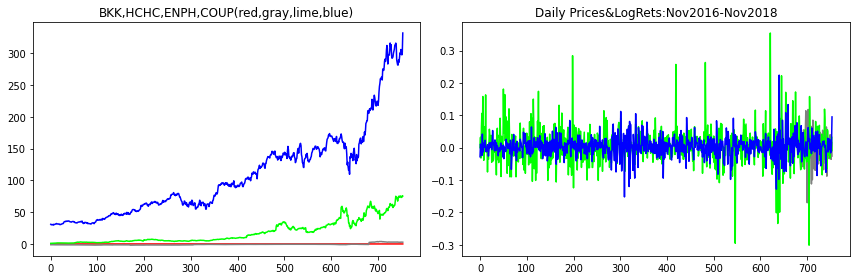

4


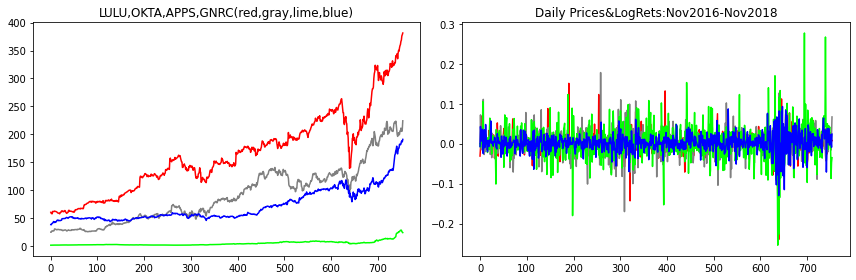

8


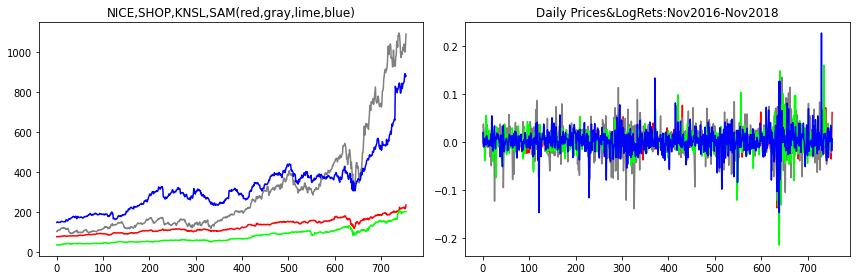

In [20]:
def findTopSRcandid(SR,k):
    idxVec = list(); found = 0
    while found < k:
        idx = np.argmax(SR)
        idxVec.append(idx) 
        SR[idx] = -10000 #disqualify SR[idx]
        found += 1
    return idxVec

start = time.time()
idxVec = findTopSRcandid(SR,k)
end   = time.time()
print("%fs" % ((end-start)))

l = [lab[int(index)] for index in idxVec]
print(l)
for i in range(k):
  if i % 4 == 0:
    print(i)
    plotSec(l[i:(i+4)],lab,prices,R)

### These k=12 names are best candidates for next quarter
### We repeat this process going back in time to obtain a back-test

<a href="Part2.2021.ipynb">Open part 2 of this tutorial</a>